# Übungsblatt 4 #

### Alice Ziegler, Daniel Schneider ###

## Aufgabe 4.1: Dimensionsreduktion ##

#### Laden und Vorbereiten des `automobile`-Datensatzes ####

In [164]:
import pandas as pd
import numpy as np
import math

In [5]:
namesString = ["symboling", "normalized-losses", "make", "fuel-type", "aspiration", "num-of-doors", "body-style", 
               "drive-wheels", "engine-location", "wheel-base", "length", "width", "height", "curb-weight", "engine-type", 
               "num-of-cylinders", "engine-size", "fuel-system", "bore", "stroke", "compression-ratio", "horsepower", 
               "peak-rpm", "city-mpg", "highway-mpg", "price"]
#data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",header=None,na_values="?",names=namesString)
data = pd.read_csv("imports-85.data",header=None,na_values="?",names=namesString)

In [6]:
data = data.dropna()

In [7]:
data.symboling = data.symboling.astype(dtype="category")
data.symboling.cat.set_categories([-3,-2,-1,0,1,2,3], inplace=True)
data.symboling.cat.reorder_categories([-3,-2,-1,0,1,2,3], ordered=True, inplace=True)

data['num-of-doors'] = data['num-of-doors'].astype(dtype="category")
data['num-of-doors'].cat.set_categories(['two', 'four'], inplace=True)
data['num-of-doors'].cat.reorder_categories(['two', 'four'], ordered=True, inplace=True)

data['num-of-cylinders'] = data['num-of-cylinders'].astype(dtype="category")
data['num-of-cylinders'].cat.set_categories(['eight', 'five', 'four', 'six', 'three', 'twelve', 'two'], inplace=True)
data['num-of-cylinders'].cat.reorder_categories(['two', 'three', 'four', 'five', 'six', 'eight', 'twelve'], ordered=True, inplace=True)

In [8]:
data['make'] = data['make'].astype("category")
data['fuel-type'] = data['fuel-type'].astype("category")
data['aspiration'] = data['aspiration'].astype("category")
data['body-style'] = data['body-style'].astype("category")
data['drive-wheels'] = data['drive-wheels'].astype("category")
data['engine-location'] = data['engine-location'].astype("category")
data['engine-type'] = data['engine-type'].astype("category")
data['fuel-system'] = data['fuel-system'].astype("category")

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 3 to 204
Data columns (total 26 columns):
symboling            159 non-null category
normalized-losses    159 non-null float64
make                 159 non-null category
fuel-type            159 non-null category
aspiration           159 non-null category
num-of-doors         159 non-null category
body-style           159 non-null category
drive-wheels         159 non-null category
engine-location      159 non-null category
wheel-base           159 non-null float64
length               159 non-null float64
width                159 non-null float64
height               159 non-null float64
curb-weight          159 non-null int64
engine-type          159 non-null category
num-of-cylinders     159 non-null category
engine-size          159 non-null int64
fuel-system          159 non-null category
bore                 159 non-null float64
stroke               159 non-null float64
compression-ratio    159 non-null float64
horsep

### a) Distanzmatrix ###

In [235]:
def dist(x,y,mins,maxs):
    types = x.dtypes
    attribs = x.columns
    
    dist = 0
    
    for f in range(0, x.shape[1]):
        
        if types[f].name == "category":
            if x[attribs[f]].cat.ordered:
                #print (str(types[f])+": Ordinal")
                dist += distOrdinal(x[attribs[f]],y[attribs[f]])
            else:
                #print(str(types[f])+": Nominal")
                dist += distNominal(x[attribs[f]],y[attribs[f]])
        else:
            #print (str(types[f])+": Numerisch")
            dist += distNumeric(x[attribs[f]],y[attribs[f]],mins[f], maxs[f])
    
    return dist

In [199]:
def distOrdinal(x,y):
    rankCount = len(x.cat.categories)
    
    rankX = (int(x.cat.codes))/(rankCount - 1)
    rankY = (int(y.cat.codes))/(rankCount - 1)    
    dist = abs(rankX - rankY)
    
    #print(dist)
    return dist

In [200]:
def distNominal(x,y):
    dist = abs(int(x.cat.codes) - int(y.cat.codes))
    
    #print (dist)
    return dist

In [201]:
def distNumeric(x,y,minim,maxim):
    dist = abs(float(x) - float(y))/(maxim - minim)
    
    #print(dist)
    return dist

In [237]:
def distMatrix(dataFrame):
    size = dataFrame.shape[0]
    
    attribs = dataFrame.columns
    types = dataFrame.dtypes
    mins = []
    maxs = []
    for f in range(0,dataFrame.shape[1]):
        if types[f].name != "category":
            mins.append(dataFrame[attribs[f]].min())
            maxs.append(dataFrame[attribs[f]].max())
        else:
            mins.append(0)
            maxs.append(0)
    
    
    array = np.empty([size, size])
        
    for i in range(0,size):        
        for j in range(0,size):
            if j < i:
                array[i,j] = array[j,i]
            else:
                array[i,j] = (dist(dataFrame.iloc[[i]],dataFrame.iloc[[j]],mins,maxs))
        
    print(array)

In [240]:
distMatrix(data)

[[  0.           2.250093     2.31582995 ...,  24.09166476  26.26981775
   22.44341232]
 [  2.250093     0.           2.44710283 ...,  24.02471352  27.04645097
   22.98038695]
 [  2.31582995   2.44710283   0.         ...,  22.4172221   25.20323544
   21.189803  ]
 ..., 
 [ 24.09166476  24.02471352  22.4172221  ...,   0.           8.61790617
    4.13054653]
 [ 26.26981775  27.04645097  25.20323544 ...,   8.61790617   0.
    5.49070446]
 [ 22.44341232  22.98038695  21.189803   ...,   4.13054653   5.49070446
    0.        ]]


### b) MDS ###

In [315]:
import scipy.spatial.distance as scp
import matplotlib.pyplot as plt

In [388]:
data2 = data[['horsepower','peak-rpm','city-mpg','highway-mpg','price']]

In [389]:
D = scp.squareform(scp.pdist(data2))

In [390]:
A = np.multiply(np.square(D),-0.5)

In [391]:
ai_ = np.mean(A,axis=0)
a_j = np.mean(A,axis=1)
a__ = np.mean(A)

ai_ = ai_[np.newaxis, :]
a_j = a_j[:, np.newaxis]

In [392]:
B = A - ai_ - a_j + a__

In [403]:
B

array([[  6.42054139e+06,   1.51855998e+07,   1.58366706e+07, ...,
          2.52904461e+07,   2.74866369e+07,   2.81065681e+07],
       [  1.51855998e+07,   3.62009273e+07,   3.77619030e+07, ...,
          6.04285125e+07,   6.60717594e+07,   6.72343525e+07],
       [  1.58366706e+07,   3.77619030e+07,   3.93905138e+07, ...,
          6.30384963e+07,   6.89380031e+07,   7.01408433e+07],
       ..., 
       [  2.52904461e+07,   6.04285125e+07,   6.30384963e+07, ...,
          1.00937685e+08,   1.10554879e+08,   1.12343047e+08],
       [  2.74866369e+07,   6.60717594e+07,   6.89380031e+07, ...,
          1.10554879e+08,   1.21633161e+08,   1.23153717e+08],
       [  2.81065681e+07,   6.72343525e+07,   7.01408433e+07, ...,
          1.12343047e+08,   1.23153717e+08,   1.25058414e+08]])

In [412]:
eigenwerte, eigenvektoren = np.linalg.eig(B)

In [413]:
eigenvektoren = np.real(eigenvektoren)
eigenwerte = np.real(eigenwerte)

In [415]:
eigenvektoren

array([[  3.38166899e-02,  -7.28849946e-02,  -3.94947943e-02, ...,
         -3.55658204e-02,   4.62952890e-02,  -4.67584840e-02],
       [  8.11797336e-02,  -8.12020868e-02,  -4.07019521e-02, ...,
         -8.53846217e-04,   2.85667777e-03,  -2.87511315e-03],
       [  8.46977581e-02,  -8.18034681e-02,  -6.78407865e-02, ...,
         -1.07605148e-02,   2.46516760e-02,  -2.47770317e-02],
       ..., 
       [  1.35782596e-01,  -9.07934506e-02,  -3.61998045e-02, ...,
         -6.59767799e-03,   1.26504629e-02,  -1.33136389e-02],
       [  1.49239873e-01,   2.82983370e-02,  -1.32518836e-01, ...,
          4.17845002e-03,  -9.75717500e-05,  -1.07238448e-03],
       [  1.51226582e-01,  -7.61050516e-02,  -1.32894256e-01, ...,
          1.49604757e-02,  -7.75237018e-03,   8.71318191e-03]])

In [450]:
sorting = eigenwerte.argsort()[::-1]   
eigenwerte_s = eigenwerte[sorting]
eigenvektoren_s = eigenvektoren[:,sorting]

dataNeu = eigenvektoren_s[:,:2]
dataNeu[:,0] = np.multiply(dataNeu[:,0],math.sqrt(eigenwerte_s[0]))
dataNeu[:,1] = np.multiply(dataNeu[:,1],math.sqrt(eigenwerte_s[1]))

In [451]:
dataNeu

array([[  2.49874998e+03,  -4.20352538e+02],
       [  5.99845397e+03,  -4.68320036e+02],
       [  6.25840442e+03,  -4.71788406e+02],
       [  1.24228979e+04,  -5.56338615e+02],
       [  4.97438242e+03,  -7.54121110e+02],
       [  5.46933176e+03,  -7.60874834e+02],
       [  9.53524081e+03,   7.33344771e+02],
       [  9.67022699e+03,   7.31502846e+02],
       [ -6.29411677e+03,   1.00482483e+02],
       [ -5.15424342e+03,  -2.15418564e+02],
       [ -4.87427208e+03,  -2.19238853e+02],
       [ -5.87854547e+03,  -3.05513267e+02],
       [ -5.07362119e+03,  -3.16517351e+02],
       [ -3.49363659e+03,  -3.38584714e+02],
       [ -5.22160604e+03,  -3.14498055e+02],
       [ -4.75865343e+03,  -3.20815176e+02],
       [ -3.84174729e+03,  -3.33326622e+02],
       [ -2.52293875e+03,   1.48360333e+02],
       [  1.51988203e+03,   9.23754636e+01],
       [ -4.96210398e+03,   3.82171548e+02],
       [ -4.60249045e+03,  -8.23052943e+02],
       [ -6.05156103e+03,  -3.03036366e+02],
       [ -

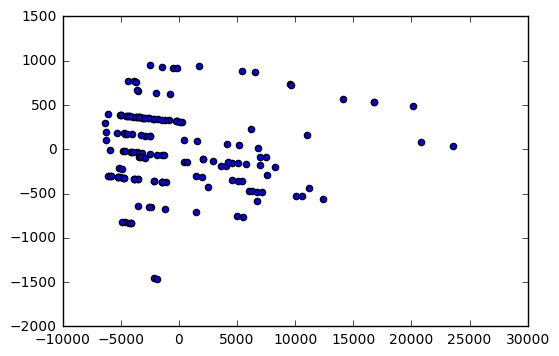

In [452]:
plt.scatter(dataNeu[:,0],dataNeu[:,1])
plt.show()

### c) Stress ###

In [453]:
D2 = scp.squareform(scp.pdist(dataNeu))

In [454]:
def stress(D1,D2):
    zaehlersumme = 0
    nennersumme = 0
    for i in range(0,D1.shape[0]):
        for j in range(i+1,D1.shape[0]):
            zaehlersumme += (D1[i,j] - D2[i,j])**2
            nennersumme += D1[i,j]**2
    
    return zaehlersumme / nennersumme

In [455]:
stress(D,D2)

3.979343482827991e-09

Der Stress beträgt: `~ 3.979e-09` ist also recht klein.

## Aufgabe 4.2: Distanzmaße ##

### a) Beweis: Gemischte Distanzfunktion ist eine Metrik ###

Sei $p$ die Anzahl der Attribute unterschiedlichen Typs.
 
Zu zeigen: Die Funktion $ d: X \times X \to \mathbb {R} $ mit

$$
d(x_i,x_j) = \frac{\sum_{f=1}^p \delta_{ij}^{(f)} d_{ij}^{(f)}} {\sum_{f=1}^p \delta_{ij}^{(f)}}
$$

ist eine Metrik, wenn $d_{ij}^{(f)}$ metrisch ist.



Es müssen dafür die folgenden 3 Axiome gelten:

1. Positive Definitheit: 
$d (x_i, x_j) \geq 0$ und $d (x_i, x_j) = 0 \Leftrightarrow x_i = x_j$

2. Symmetrie: 
$d (x_i, x_j) = d (x_j, x_i)$

3. Dreiecksungleichung: 
$d (x_i, x_j) \leq d (x_i, x_k) + d (x_k, x_j)$

Es sei $d_{ij}^{(f)}$ eine Metrik. Dann dürfen keine $x_{if}$ undefiniert sein, da alle Distanzen bestimmbar sein müssen.

**Zu 1. **

Zu zeigen: $d (x_i, x_j) \geq 0$

* Nach Voraussetzung gilt: $d_{ij}^{(f)} \geq 0$ für alle $f \in \{1,...,p\}$.

  Für den binären Indikator $\delta_{ij}^{(f)}$ gilt nach Definition: 

     $\delta_{ij}^{(f)} \in {0,1}$ für alle $i,j \in \{1,...,n\}$ und $f \in \{1,...,p\}$, also $\delta_{ij}^{(f)} \geq 0$

   Daraus folgt: 
   $$
   \frac{\sum_{f=1}^p \delta_{ij}^{(f)} d_{ij}^{(f)}} {\sum_{f=1}^p \delta_{ij}^{(f)}} \geq 0 \Leftrightarrow d (x_i, x_j) \geq 0
   $$ 


Noch zu zeigen: $d (x_i, x_j) = 0 \Leftrightarrow x_i = x_j$. Zeige dazu beide Richtungen:

* $\Leftarrow$

  Wenn $x_i = x_j$, dann folgt, weil $d_{ij}^{(f)}$ metrisch ist, dass $d_{ij}^{(f)} = 0$ für alle $f \in \{1,...,p\}$ und daraus folgt: $\frac{\sum_{f=1}^p \delta_{ij}^{(f)} d_{ij}^{(f)}} {\sum_{f=1}^p \delta_{ij}^{(f)}} = 0 \Leftrightarrow d (x_i, x_j) = 0$ 


* $\Rightarrow$

  Sei nun $d (x_i, x_j) = 0$, dann muss $\sum_{f=1}^p \delta_{ij}^{(f)} d_{ij}^{(f)} = 0$ sein. Betrachte zwei Fälle:

  1. Falls $d_{ij}^{(f)} = 0$ für alle $f \in \{1,...,p\}$ gilt nach Voraussetzung $x_i = x_j$.

  2. Angenommen es gäbe ein $f_x \in \{1,...,p\}$ sodass $d_{ij}^{(f_x)} \neq 0$. Dann folgt daraus, dass $\delta_{ij}^{(f_x)} = 0$ sein muss. Dies ist allerdings nur der Fall, wenn $x_{if_x} = x_{jf_x}$ (für ein binäres asymetrisches Attribut $f_x$). Und dann gilt weiterhin $x_i = x_j$.


* Zusammen gilt also: 
$$
d (x_i, x_j) = 0 \Leftrightarrow x_i = x_j
$$

**Zu 2.**

Zu zeigen: $d (x_i, x_j) = d (x_j, x_i)$

* Nach Voraussetzung gilt: $d_{ij}^f = d_{ji}^f$ für alle $f \in \{1,...,p\}$

  Und auch für $\delta_{ij}^{(f)}$ gilt nach Definition, dass $\delta_{ij}^{(f)} = \delta_{ji}^{(f)}$ für alle $i,j \in \{1,...,n\}$ und $f \in \{1,...,p\}$

  Also gilt auch: $\sum_{f=1}^p \delta_{ij}^{(f)} d_{ij}^{(f)} = \sum_{f=1}^p \delta_{ij}^{(f)} d_{ji}^{(f)}$
  
  Und daraus folgt: 
  $$
  \frac{\sum_{f=1}^p \delta_{ij}^{(f)} d_{ij}^{(f)}} {\sum_{f=1}^p \delta_{ij}^{(f)}} = \frac{\sum_{f=1}^p \delta_{ji}^{(f)} d_{ji}^{(f)}} {\sum_{f=1}^p \delta_{ji}^{(f)}} \Leftrightarrow d (x_i, x_j) = d (x_j, x_i)
  $$


**Zu 3.**

Zu zeigen: $d (x_i, x_j) \leq d (x_i, x_k) + d (x_k, x_j)$

* Nach Voraussetzung gilt: $d_{ij}^f \leq d_{ik}^f + d_{kj}^f$ für alle $f \in \{1,...,p\}$
  
  Für $\delta_{ij}^{(f)}$ wiederum gilt:
  
  Falls $\delta_{ik}^{(f)} = 0$ oder $\delta_{kj}^{(f)} = 0$ folgt daraus, dass auch $\delta_{ij}^{(f)} = 0$ sein muss, da die Null nur angenommen wird, wenn zwei Attribute übereinstimmen. Es gilt also (da $\delta_{ik}^{(f)} \in \{0,1\}$) : $\delta_{ij}^{(f)} \leq \delta_{ik}^{(f)} + \delta_{kj}^{(f)}$.
  
  Und daraus folgt:
  $$
  \frac{\sum_{f=1}^p \delta_{ij}^{(f)} d_{ij}^{(f)}} {\sum_{f=1}^p \delta_{ij}^{(f)}} \leq 
  \frac{\sum_{f=1}^p \delta_{ik}^{(f)} d_{ik}^{(f)}} {\sum_{f=1}^p \delta_{ik}^{(f)}} + \frac{\sum_{f=1}^p \delta_{kj}^{(f)} d_{kj}^{(f)}} {\sum_{f=1}^p \delta_{kj}^{(f)}}
  \Leftrightarrow
  d (x_i, x_j) \leq d (x_i, x_k) + d (x_k, x_j)
  $$

### b) Speicherkomplexität von Distanzmatrizen ###

Die Speicherkomplexität der Distanzmatrix für $n$ Werte beträgt $O(n^2)$

Durch die symmetrie der Distanzen steht jeder Distanzwert zwei Mal in der Matrix, einmal an Position $i,j$ und noch einmal an Position $j,i$. Um Speicherplatz zusparen müsste man eine andere Datenstruktur als eine Matrix wählen, sodass die doppelten Werte nur einmal gespeichert werden müssen. 

Beispielsweise könnte man eine Liste der Distanzen speichern und zu jedem Distanzeintrag die beiden betreffenden Punkte (Start und Ende) speichern. Dies kann allerdings zu anderen Problemen führen, wenn beispielsweise ein Pfad verfolgt werden soll und um die Distanzen zu ermitteln jedes Mal zwei Punktelisten nach dem Startpunkt der aktuellen Strecke durchsucht werden müssen.

## Aufgabe 4.3: Verzerrte Werte ##

### a) Nicht-Erwartungstreue des Schätzers der Varianz ###

### b) Korrektur des Schätzers ###